In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/논문/Youtube-Recommendation/Movie-Lens

/content/drive/MyDrive/논문/Youtube-Recommendation/Movie-Lens


In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [51]:
dataset = pd.read_pickle('./dataset.pkl')

In [52]:
dataset

,userID,profile,recent,label,like,dislike,profile_a,profile_b,profile_c,profile_d,profile_scale
0,1,"[39.0, 17.0, 173.0, 689.5]",[473],3143,[473],[],39.0,17.0,173.0,689.5,"[0.0005389345678159332, 0.0033405384161917864,..."
1,3,"[128.0, 90.0, 267.0, 1185.5]","[28384, 43893, 49041, 26549, 50701, 6108, 3855...",39572,"[38554, 38554, 50701, 26549, 49041, 43893, 136...","[3487, 80, 6112, 1365, 1760, 9229, 45157, 9615...",128.0,90.0,267.0,1185.5,"[0.001768810889242037, 0.01768520337983887, 0...."
2,4,"[45.0, 47.0, 200.0, 704.0]",[],18012,[],[],45.0,47.0,200.0,704.0,"[0.0006218475782491537, 0.00923560620947141, 0..."
3,5,"[2848.0, 103.0, 582.0, 2209.5]","[78, 6182, 1395, 821]",6689,"[6182, 821, 1395, 78]",[],2848.0,103.0,582.0,2209.5,"[0.03935604228563532, 0.020239732756926705, 0...."
4,7,"[54.0, 33.0, 1233.0, 4173.0]",[],11455,[],[],54.0,33.0,1233.0,4173.0,"[0.0007462170938989844, 0.006484574572607585, ..."
...,...,...,...,...,...,...,...,...,...,...,...
35825,52190,"[47.0, 53.0, 1001.0, 3742.5]",[13553],20448,[13553],[],47.0,53.0,1001.0,3742.5,"[0.0006494852483935605, 0.010414619768127334, ..."
35826,52191,"[0.0, 0.0, 8.0, 29.0]",[],23478,[],[],0.0,0.0,8.0,29.0,"[0.0, 0.0, 0.0004810583283223091, 0.0004919006..."
35827,52192,"[0.0, 0.0, 2.0, 5.5]",[],12967,[],[],0.0,0.0,2.0,5.5,"[0.0, 0.0, 0.00012026458208057727, 9.329149351..."
35828,52193,"[1.0, 2.0, 17.0, 73.5]",[],2573,[],[],1.0,2.0,17.0,73.5,"[1.3818835072203414e-05, 0.0003930045195519748..."


In [7]:
dataset.head()

,userID,profile,recent,label,like,dislike
0,1,"[39.0, 17.0, 173.0, 689.5]",[473],3143,[473],[]
1,3,"[128.0, 90.0, 267.0, 1185.5]","[28384, 43893, 49041, 26549, 50701, 6108, 3855...",39572,"[38554, 38554, 50701, 26549, 49041, 43893, 136...","[3487, 80, 6112, 1365, 1760, 9229, 45157, 9615..."
2,4,"[45.0, 47.0, 200.0, 704.0]",[],18012,[],[]
3,5,"[2848.0, 103.0, 582.0, 2209.5]","[78, 6182, 1395, 821]",6689,"[6182, 821, 1395, 78]",[]
4,7,"[54.0, 33.0, 1233.0, 4173.0]",[],11455,[],[]


In [8]:
dataset2 = dataset.loc[dataset['recent'].apply(lambda x : len(x)) > 3]

In [9]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES = 50858
LEARNING_RATE = 0.003 

In [10]:
import tensorflow as tf
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}

In [11]:
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask
    

In [65]:
#---inputs
import tensorflow as tf
import datetime
import os
input_recent = tf.keras.Input(shape=(None, ), name='recent')
inp_liked = tf.keras.layers.Input(shape=(None,), name='like')
inp_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
input_profile = tf.keras.Input(shape=(4, ), name='profile')


#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS, 
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

# --- features

# features_embeddings = features_embedding_layer(input_profile)
# l2_norm_features = l2_norm_1(features_embeddings)
# avg_features = avg_embeddings(l2_norm_features)

# dense_profile = tf.keras.layers.Dense(units = 16, name='dense_profile')
# dense_1_profile = dense_profile(input_profile)
# dense_1_profile_relu = tf.keras.layers.ReLU(name='dense_1_profile_relu')(dense_1_profile)



labels_liked_embeddings = labels_embedding_layer(inp_liked)
l2_norm_liked = l2_norm_1(labels_liked_embeddings)
avg_liked = avg_embeddings(l2_norm_liked)

labels_disliked_embeddings = labels_embedding_layer(inp_disliked)
l2_norm_disliked = l2_norm_1(labels_disliked_embeddings)
avg_disliked = avg_embeddings(l2_norm_disliked)

labels_genre_embeddings = labels_embedding_layer(input_recent)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_recent = avg_embeddings(l2_norm_genre)



concat_inputs = tf.keras.layers.Concatenate(axis=1)([
                                                    #  avg_features,
                                                    #  dense_1_profile_relu,
                                                     avg_liked,
                                                     avg_disliked,
                                                     avg_recent
                                                     ])
# Dense Layers
dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
#dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[
            # input_profile,
            inp_liked, 
            inp_disliked
            ,input_recent
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy')

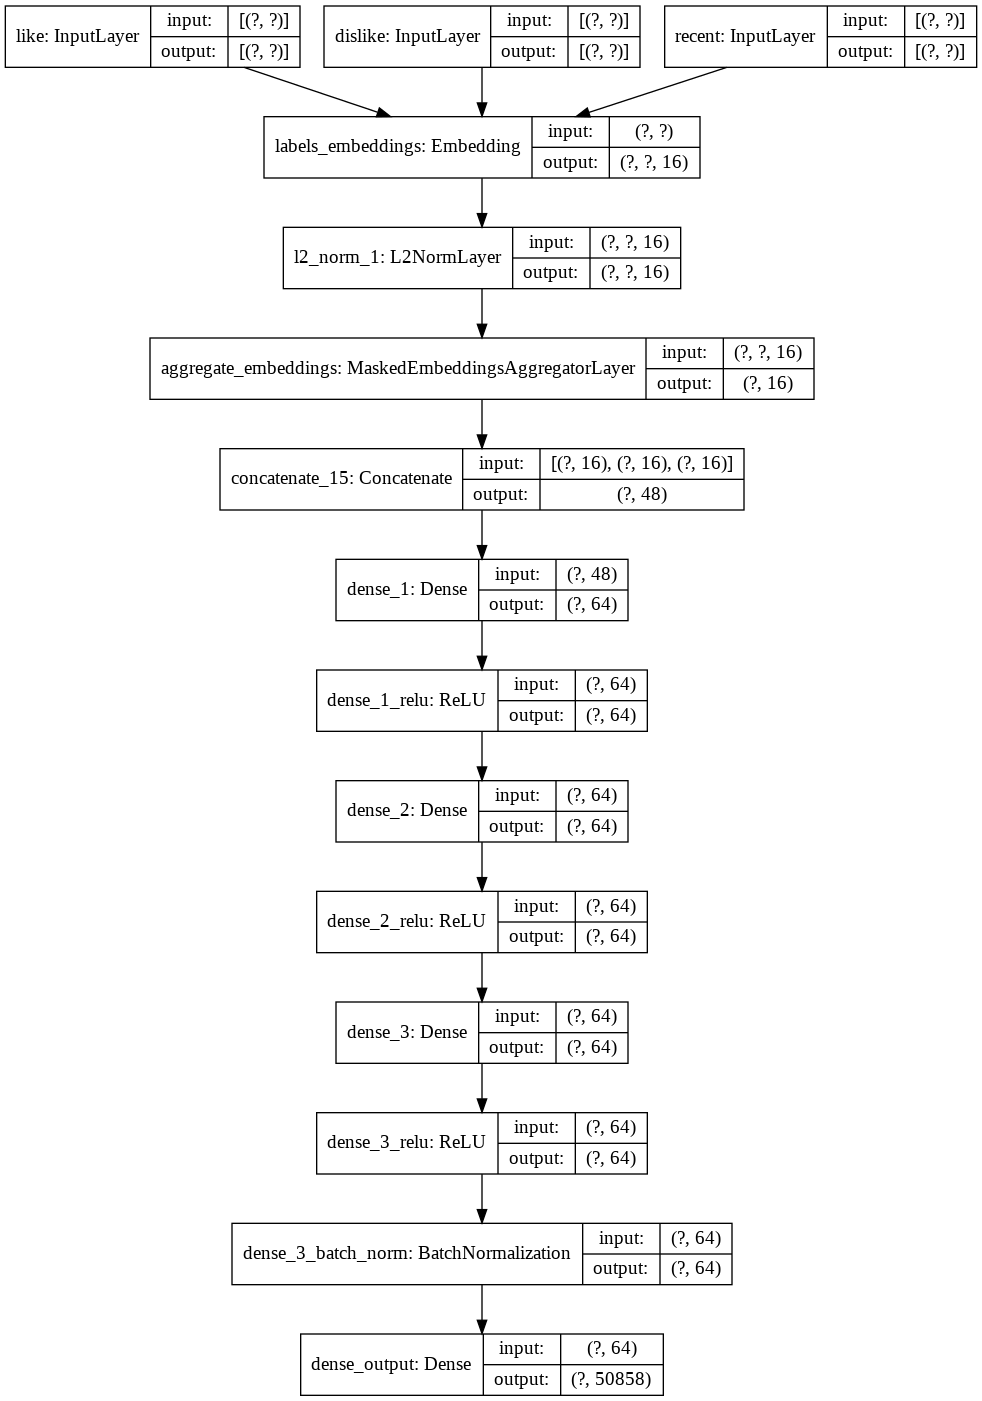

In [66]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [67]:
model.fit([
          #  tf.keras.preprocessing.sequence.pad_sequences(dataset['profile_scale']),
           tf.keras.preprocessing.sequence.pad_sequences(dataset['like']),
           tf.keras.preprocessing.sequence.pad_sequences(dataset['dislike']),
           tf.keras.preprocessing.sequence.pad_sequences(dataset['recent'])
           ],
          dataset['label'].values,
          # callbacks=[tensorboard_callback],
          # batch_size = 32,
          steps_per_epoch=1,
          epochs = 500,
          # verbose=1
          )

Epoch 1/500


ResourceExhaustedError: ignored

In [99]:
dataset

,userID,profile,recent,label,like,dislike
0,1,"[39.0, 17.0, 173.0, 689.5]",[473],3143,[473],[]
1,3,"[128.0, 90.0, 267.0, 1185.5]","[28384, 43893, 49041, 26549, 50701, 6108, 3855...",39572,"[38554, 38554, 50701, 26549, 49041, 43893, 136...","[3487, 80, 6112, 1365, 1760, 9229, 45157, 9615..."
2,4,"[45.0, 47.0, 200.0, 704.0]",[],18012,[],[]
3,5,"[2848.0, 103.0, 582.0, 2209.5]","[78, 6182, 1395, 821]",6689,"[6182, 821, 1395, 78]",[]
4,7,"[54.0, 33.0, 1233.0, 4173.0]",[],11455,[],[]
...,...,...,...,...,...,...
35825,52190,"[47.0, 53.0, 1001.0, 3742.5]",[13553],20448,[13553],[]
35826,52191,"[0.0, 0.0, 8.0, 29.0]",[],23478,[],[]
35827,52192,"[0.0, 0.0, 2.0, 5.5]",[],12967,[],[]
35828,52193,"[1.0, 2.0, 17.0, 73.5]",[],2573,[],[]


In [49]:
predict = model.predict([
                        tf.keras.preprocessing.sequence.pad_sequences(dataset['like']),
                        tf.keras.preprocessing.sequence.pad_sequences(dataset['dislike']),
                        tf.keras.preprocessing.sequence.pad_sequences(dataset['recent'])
])
                                                                  

ResourceExhaustedError: ignored

In [19]:
import numpy as np

In [45]:
predictions = np.array([np.argmax(a) for a in predict])
pd.DataFrame(predictions)

,0
0,2259
1,0
2,31205
3,6713
4,30480
...,...
6224,33686
6225,23527
6226,0
6227,34690


In [64]:
dataset2['label'].value_counts()

549      47
599      42
28520    41
9327     39
4141     39
         ..
3075      1
2532      1
21504     1
9214      1
2049      1
Name: label, Length: 3636, dtype: int64

In [63]:
pd.DataFrame(predictions).value_counts()

0        1824
8322      290
16102     203
43993     194
45279     160
         ... 
25853       1
13321       1
40386       1
31349       1
40107       1
Length: 534, dtype: int64

In [ ]:
print(tf.argsort(predict,direction='DESCENDING',axis=-1))

In [ ]:
tf.nn.top_k(
    predict,
    k=20,
    sorted=True,
    name=None
)

In [ ]:
s=[i for i in range(len(movie2movie_encoded)) if movie2movie_encoded[i] == 365 ]

In [ ]:
movies[movies.movie_id == ''.join(str(s[0]))]

### Visualize Embeddings 

In [37]:
import io
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
#weights =model.layers[4].get_weights()[0]
weights = features_embedding_layer.get_weights()[0][1:]

for num, word in enumerate(title2title_encoded):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

NameError: ignored

In [38]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>